<a href="https://colab.research.google.com/github/AristovDaniil/Machine-Learning/blob/main/Lab2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Инициализация среды
import sys, os
import gym
import numpy as np
env = gym.make("Taxi-v3")
env.reset()
env.render()
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states=%i, n_actions=%i" % (n_states, n_actions))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

n_states=500, n_actions=6


In [ ]:
#policy[s,a] = P(выполнить действие a | в состоянии s)
#Создание стохастической политики
def initialize_policy(n_states, n_actions):
    # Инициализация равномерной политики (все вероятности равны 1/n_actions)
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

policy = initialize_policy(n_states, n_actions)
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


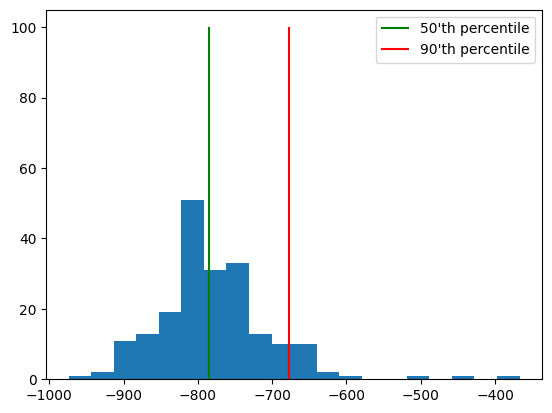

In [ ]:
#Игра с моделью
def generate_session(env, policy, t_max=10**4):
    """
    Играть до конца или t_max тиков.
    :param policy: массив вида [n_states, n_actions] с вероятностями действий
    :returns: список состояний, список действий и сумма наград
    """
    states, actions = [], []
    total_reward = 0.
    s = env.reset()
    for t in range(t_max):
        # Выбор действия на основе вероятностей в policy
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, done, info = env.step(a)
        # Запись информации, полученной из среды
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]

# Визуализация начального распределения вознаграждений
import matplotlib.pyplot as plt

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()
plt.show()


In [ ]:
#Шаги кросс-энтропийного метода
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Выберите состояния и действия из игры, которые имеют награды >= процентиль
    """
    # Вычисление минимального вознаграждения для лучших сессий
    reward_threshold = np.percentile(rewards_batch, percentile)

    # Выбор элитных состояний и действий
    elite_states = [s for i, s in enumerate(states_batch) if rewards_batch[i] >= reward_threshold]
    elite_actions = [a for i, a in enumerate(actions_batch) if rewards_batch[i] >= reward_threshold]

    # Преобразование списков списков в одномерные списки
    elite_states = np.concatenate(elite_states)
    elite_actions = np.concatenate(elite_actions)

    return elite_states, elite_actions

states_batch = [
    [1, 2, 3],  # игра 1
    [4, 2, 0, 2],  # игра 2
    [3, 1],  # игра 3
]
actions_batch = [
    [0, 2, 4],  # игра 1
    [3, 2, 0, 1],  # игра 2
    [3, 3],  # игра 3
]
rewards_batch = [
    3,  # игра 1
    4,  # игра 2
    5,  # игра 3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3])
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3])
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3])
assert np.all(test_result_100[0] == [3, 1]) and \
    np.all(test_result_100[1] == [3, 3])


In [ ]:
#Обновление политики
def get_new_policy(elite_states, elite_actions):
    """
    Учитывая список лучших состояний/действий от select_elites,
    возвращает новую политику.
    """
    new_policy = np.zeros((n_states, n_actions))

    # Подсчёт количества пар (состояние, действие)
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1

    # Нормализация, чтобы получить вероятности
    for s in range(n_states):
        if np.sum(new_policy[s]) > 0:
            new_policy[s] /= np.sum(new_policy[s])
        else:
            new_policy[s] = 1 / n_actions  # Равномерное распределение для неизвестных состояний

    return new_policy


mean reward = -35.548, threshold=5.000


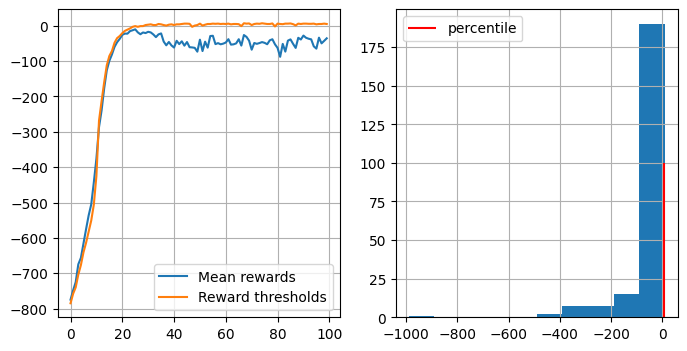

In [ ]:
# 4. Тренировочный цикл
from IPython.display import clear_output


# Сбросить политику
policy = initialize_policy(n_states, n_actions)

# Эксперимент
n_sessions = 250
percentile = 50
learning_rate = 0.5
log = []

for i in range(100):
    # Генерация списка новых сессий
    sessions = [generate_session(env, policy, t_max=1000) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # Выбор лучших состояний и действий
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # Вычисление новой политики
    new_policy = get_new_policy(elite_states, elite_actions)

    # Обновление политики
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # Отображение прогресса
    show_progress(rewards_batch, log, percentile)